### Imports
We import the necessary Python libraries:
- `requests` to fetch data from the API
- `pandas` to handle and manipulate data
- `matplotlib.pyplot` for visualizations
- `sentence_transformers` for NLP-based job classification


In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

### Test API Connection
We send a request to the Arbeitnow API to check if it responds correctly.
We print the status code, content type, and the first few characters of the response to verify.


In [10]:
import requests

page = 1
url = f"https://www.arbeitnow.com/api/job-board-api?page={page}"

resp = requests.get(url)

print("Status code:", resp.status_code)
print("Content-type:", resp.headers.get("Content-Type"))
print("First 200 chars:", resp.text[:200])

Status code: 200
Content-type: application/json
First 200 chars: {"data":[{"slug":"senior-full-stack-developer-all-genders-100-remote-eu-typescript-react-nextjs-python-berlin-136855","company_name":"b-good GmbH","title":"Senior Full Stack Developer (all genders) - 


### Fetch All Job Listings
We loop through all pages of the API to fetch all job postings.
- Stop when no more data is returned
- Collect all job postings into a list
- Convert the list into a Pandas DataFrame


In [47]:
jobs = []
page = 1

while True:
    url = f"https://arbeitnow.com/api/job-board-api?page={page}"
    resp = requests.get(url)

    if resp.status_code != 200:
        print(f"Error on page {page}: {resp.status_code}")
        break

    data = resp.json()

    if "data" not in data or not data["data"]:
        print(f"No more data at page {page}")
        break

    jobs.extend(data["data"])
    print(f"Fetched {len(data['data'])} jobs from page {page}")
    page += 1

df = pd.DataFrame(jobs)
print("Total jobs:", len(df))
df.head()


Fetched 100 jobs from page 1
Fetched 100 jobs from page 2
Fetched 100 jobs from page 3
Fetched 100 jobs from page 4
Fetched 100 jobs from page 5
Error on page 6: 429
Total jobs: 500


,slug,company_name,title,description,remote,url,tags,job_types,location,created_at
0,pre-opening-operations-manager-berlin-363656,mitte | Boutique Padel,Pre-Opening Operations Manager (m/f/d),"<p>Wir sind fest davon überzeugt, dass Padel e...",False,https://www.arbeitnow.com/jobs/companies/mitte...,[Business Operations],[],Berlin,1759485810
1,aftermarket-engineer-lubeck-205952,SPX FLOW,Aftermarket Engineer (m/w/d),"<p><strong>Ort: Lübeck, Deutschland</strong></...",False,https://www.arbeitnow.com/jobs/companies/spx-f...,[Customer Service],[berufserfahren],Lübeck,1759485809
2,freelance-social-media-marketing-manager-berli...,C+ Bakery,Freelance Social Media & Marketing Manager,"<p>At <strong>C+ Bakery</strong>, we blend con...",False,https://www.arbeitnow.com/jobs/companies/c-bak...,[Marketing Manager],"[Freelance, professional / experienced]",Berlin,1759484050
3,founders-assistant-facility-services-gottingen...,Coeles Group,Founder’s Assistant Facility Services (m/w/d),<p>Das Unternehmen Gartenservice Krause wurde ...,False,https://www.arbeitnow.com/jobs/companies/coele...,[Project Management],[],Göttingen,1759484049
4,ai-developer-ki-entwickler-100-remote-worms-4573,Powerprozesse,AI-Developer / KI-Entwickler (m/w/d) 100% remote,"<p style="";""></p><img style=""width: 2840px"" sr...",False,https://www.arbeitnow.com/jobs/companies/power...,"[Information technology, professional]","[Full-time permanent, mid]",Worms,1759483212


### Define Job Categories
We create a list of broad industry categories that we want to classify jobs into.
These categories will later be used with an NLP model for semantic classification.


In [52]:
categories = [
    "IT & Software",
    "Sales & Marketing",
    "Healthcare",
    "Finance & Accounting",
    "Logistics & Transport",
    "Education & Research",
    "Construction & Engineering",
    "Retail & Hospitality",
    "Management & Consulting",
    "Other"
]


### Load Multilingual NLP Model
We use Sentence-BERT (`paraphrase-multilingual-MiniLM-L12-v2`) to create embeddings.
- Multilingual model handles both German and English job titles
- We precompute embeddings for each category


In [49]:
# Multilingual model works for German + English
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Precompute category embeddings
category_embeddings = model.encode(categories, convert_to_tensor=True)


### Classify Jobs Using NLP
- Each job title is converted into an embedding
- Cosine similarity is computed with each category embedding
- The category with the highest similarity is assigned


In [50]:
def classify_job(title):
    if not isinstance(title, str) or title.strip() == "":
        return "Other"
    
    # Encode job title
    job_embedding = model.encode(title, convert_to_tensor=True)
    
    # Compare with category embeddings
    scores = util.cos_sim(job_embedding, category_embeddings)[0]
    
    # Pick best match
    best_idx = scores.argmax().item()
    return categories[best_idx]

# Apply classification
df["category_nlp"] = df["title"].apply(classify_job)

# Preview results
df[["title", "category_nlp"]].head(20)


,title,category_nlp
0,Pre-Opening Operations Manager (m/f/d),Management & Consulting
1,Aftermarket Engineer (m/w/d),Construction & Engineering
2,Freelance Social Media & Marketing Manager,Sales & Marketing
3,Founder’s Assistant Facility Services (m/w/d),Management & Consulting
4,AI-Developer / KI-Entwickler (m/w/d) 100% remote,IT & Software
5,Senior Software Developer mit Shopware 6 Erfah...,IT & Software
6,n8n Developer / Automation Developer (m/w/d) 1...,IT & Software
7,Automation-Developer (n8n / Zapier / Make / Po...,IT & Software
8,SAP FI Key User (m/w/d),IT & Software
9,Vertriebsmitarbeiter,Logistics & Transport


### Save Classified Jobs
We save the DataFrame with the new `category_nlp` column into a CSV file.
This allows us to analyse the data later or share it.


In [ ]:
df.to_csv("arbeitnowScrapedJobs.csv", index=False, encoding="utf-8")
print(f"Saved {len(df)} jobs to arbeitnowScrapedJobs.csv")

### Visualisation of Job Postings by Category
- We create a horizontal bar chart showing the number of jobs per category
- Labels are added inside the bars for clarity
- Bars are sorted from smallest to largest for readability


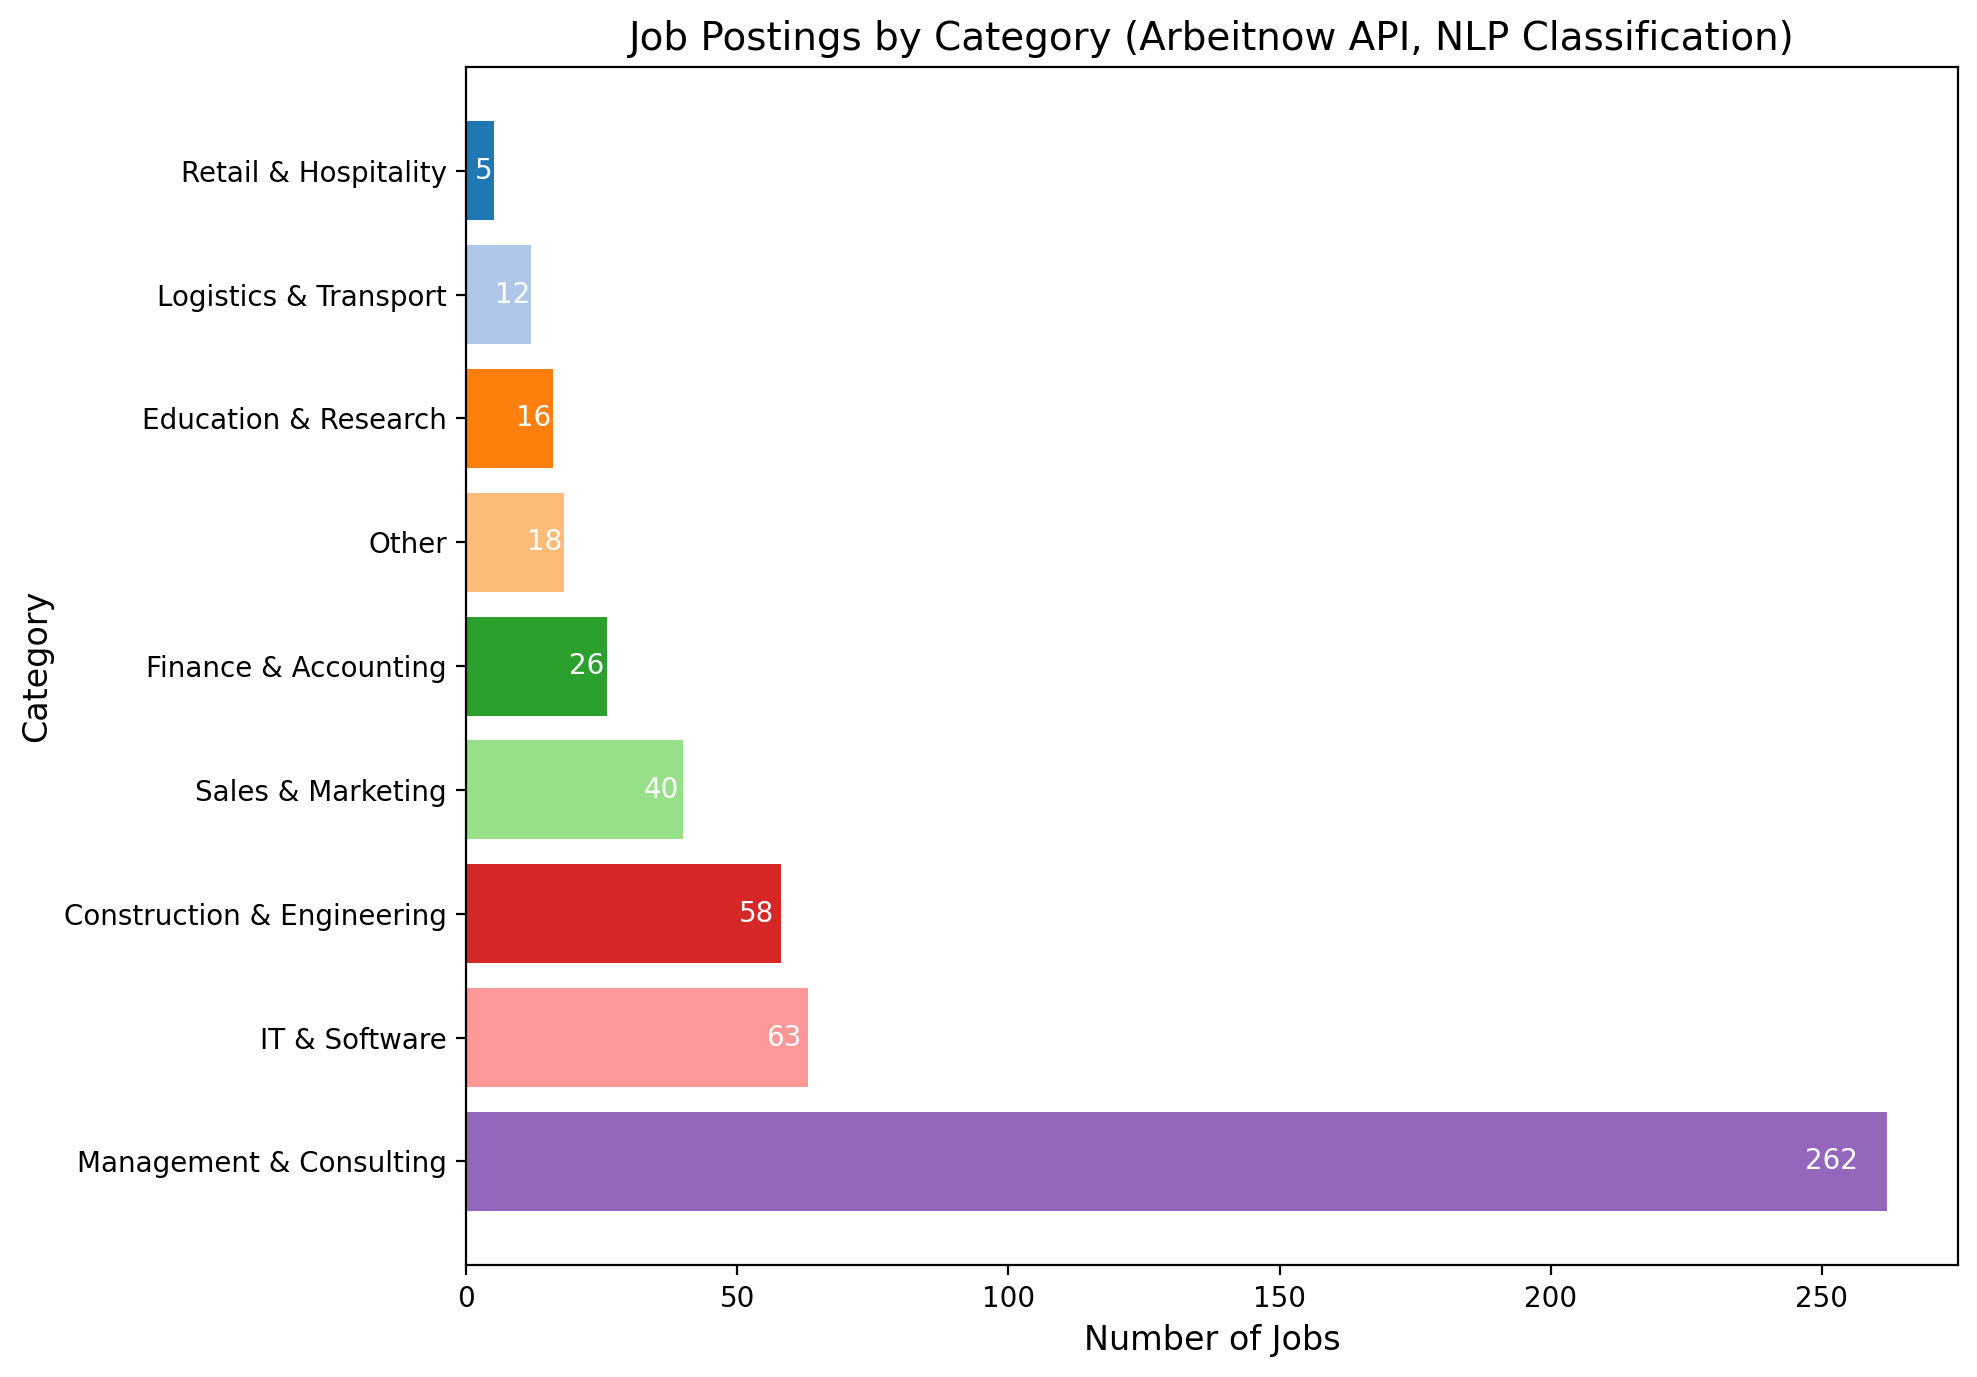

In [53]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10,7))

bars = plt.barh(counts.index, counts.values, color=colors[:len(counts)])
plt.xlabel("Number of Jobs", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.title("Job Postings by Category (Arbeitnow API, NLP Classification)", fontsize=14)

#  labels inside bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - width*0.02,  # 2% from right edge
             bar.get_y() + bar.get_height()/2, 
             str(int(width)), 
             va='center', ha='right', color='white', fontsize=10)

plt.gca().invert_yaxis()  # small to large
plt.tight_layout()
plt.show()
